<a href="https://colab.research.google.com/github/leekentvr/COMP2CAD/blob/main/9_ProComp2CAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# All required imports
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pathlib
from google.colab import files
import glob

from zipfile import ZipFile
from tensorflow import keras
#from tensorflow import layers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.callbacks import CSVLogger
import pandas as pd

from datetime import date

In [ ]:
# PARAM # Path to google drive (you should change this)
data_dir = '/content/drive/MyDrive/MachineLearningImages/Dataset/'

# PARAM # upddate filename
file_name = '2022_11_25/SlottedNuts.zip'

# PARAM # update current class (hinge etc)
current_class = "SlottedNuts"

In [ ]:
# Extract all data
with ZipFile(data_dir + file_name, 'r') as zip:
  zip.extractall('/content/out/')
  print('Done')
  zip.close()

Done


In [ ]:
# PARAM # batch size and image size (be sure to double check the image size)
batch_size = 9
img_height = 640
img_width = 600

In [ ]:
# split files into training and validation sets (80/20 split)
data_dir = '/content/out/'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16575 files belonging to 51 classes.
Using 13260 files for training.
Found 16575 files belonging to 51 classes.
Using 3315 files for validation.


In [ ]:
# Define class names 
# TODO: connect these names to the component names as a dictionary
class_names = train_ds.class_names
print(class_names)

['00015305', '00015306', '00015307', '00015308', '00015309', '00015310', '00015311', '00015312', '00015313', '00015314', '00015315', '00015316', '00015317', '00015318', '00015319', '00015320', '00015321', '00015322', '00015323', '00015324', '00015325', '00015326', '00015327', '00015328', '00015329', '00015330', '00015331', '00015332', '00015333', '00015334', '00015335', '00015336', '00015337', '00015338', '00015339', '00015340', '00015341', '00015342', '00015343', '00015344', '00015345', '00015346', '00015347', '00015348', '00015349', '00015350', '00015351', '00015352', '00015353', '00015354', '00015355']


In [ ]:
# verify images have been captured should be (batch, imagex, imagey, and 3) (batch)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(9, 640, 600, 3)
(9,)


In [ ]:
# Autotune the image dateset. Not sure how. Thanks Google.
AUTOTUNE = tf.data.AUTOTUNE

options = tf.data.Options()
options.autotune.enabled = True
dataset = train_ds.with_options(options)

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# normalise (rescale) the images to something usable
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


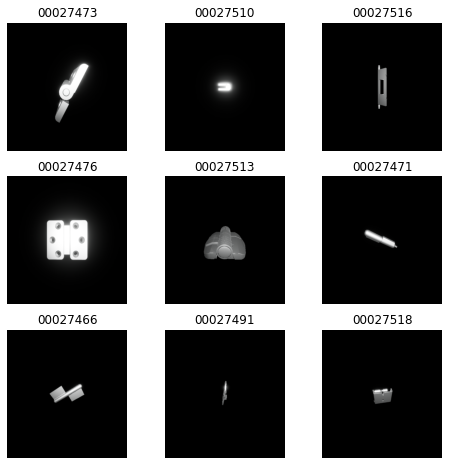

In [ ]:
#pil_img = tf.keras.preprocessing.image.array_to_img(image_batch[1])
#plt.imshow(pil_img)

# Show 9 random models from a batch
plt.figure(figsize=(8, 8))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# define the model
num_classes = len(class_names)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 640, 600, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 640, 600, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 320, 300, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 300, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 160, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 150, 64)      1

In [ ]:
# PARAM # Set output folder where you want the model to be saved to 
output_folder = '/content/drive/MyDrive/MachineLearningImages/Models/'

# SETUP CALLBACKS

today = date.today()
# YY/mm/dd
todayformatted = today.strftime("%Y/%m/%d")
print("d1 =", todayformatted)

checkpoint_filepath = output_folder + todayformatted + "/" + current_class

if not os.path.exists(checkpoint_filepath):
    os.makedirs(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=0,
    save_best_only=True,
    save_weights_only= False,
    save_freq='epoch'
)

csv_logger = CSVLogger(output_folder + todayformatted + "/" + current_class + "/" + 'training.log')

d1 = 2022/11/29


In [ ]:
# OPTION 1 
# LOAD AN OLD MODEL AND CONTINUE (for 30 steps)

# PARAM # Data model created in format YYYY/mm/dd (as this is how it was saved)
dateModelCreated = "2022/11/01"

previous_checkpoint_filepath = output_folder + dateModelCreated + "/" + current_class
print(previous_checkpoint_filepath)
loaded_model = keras.models.load_model(previous_checkpoint_filepath)

# OPTION 1
# IS THERE A CHECKPOINT TO LOAD/CONTINUE FROM
if loaded_model:
  new_history = loaded_model.fit(train_ds, epochs=epochs,
                      validation_data=val_ds,
                      validation_steps=30,
                      callbacks=[model_checkpoint_callback],
                      )

In [ ]:
# OPTION 2
epochs = 10

# Build the ML model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_checkpoint_callback, csv_logger]
)

Epoch 1/10
1474/1474 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.7008

1474/1474 [==============================] - 2003s 1s/step - loss: 1.0057 - accuracy: 0.7008 - val_loss: 0.3160 - val_accuracy: 0.8833
Epoch 2/10
1474/1474 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9332

1474/1474 [==============================] - 2041s 1s/step - loss: 0.1705 - accuracy: 0.9332 - val_loss: 0.1969 - val_accuracy: 0.9300
Epoch 3/10
1474/1474 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9491

1474/1474 [==============================] - 2035s 1s/step - loss: 0.1153 - accuracy: 0.9491 - val_loss: 0.1532 - val_accuracy: 0.9333
Epoch 4/10
1474/1474 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9624

1474/1474 [==============================] - 2030s 1s/step - loss: 0.0749 - accuracy: 0.9624 - val_loss: 0.1366 - val_accuracy: 0.9424
Epoch 5/10
1474/1474 [==============================] - 2104s 1s/step - loss: 0.0953 - accuracy: 0.9580 - val_loss: 0.2369 - val_accuracy: 0.9173
Epoch 6/10
1474/1474 [==============================] - 2047s 1s/step - loss: 0.0687 - accuracy: 0.9655 - val_loss: 0.2007 - val_accuracy: 0.9279
Epoch 7/10
1474/1474 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9716

1474/1474 [==============================] - 2126s 1s/step - loss: 0.0557 - accuracy: 0.9716 - val_loss: 0.1420 - val_accuracy: 0.9430
Epoch 8/10
1474/1474 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9736

1474/1474 [==============================] - 2086s 1s/step - loss: 0.0498 - accuracy: 0.9736 - val_loss: 0.1436 - val_accuracy: 0.9484
Epoch 9/10
1474/1474 [==============================] - 2070s 1s/step - loss: 0.0580 - accuracy: 0.9712 - val_loss: 0.1552 - val_accuracy: 0.9379
Epoch 10/10
1474/1474 [==============================] - 2071s 1s/step - loss: 0.0464 - accuracy: 0.9749 - val_loss: 0.1245 - val_accuracy: 0.9436


In [ ]:
# OPTION 3 
# LOAD AN OLD MODEL AND EVALUATE

# 1 only load weights
#history = model.load_weights(checkpoint_filepath)

# PARAM # Data model created in format YYYY/mm/dd (as this is how it was saved)
todayformatted = "2022/11/15"

previous_checkpoint_filepath = output_folder + todayformatted + "/" + current_class
print(previous_checkpoint_filepath)

# 2 load whole model
history = keras.models.load_model(previous_checkpoint_filepath)

test = model.load_weights(previous_checkpoint_filepath)

loss, acc = model.evaluate(image_batch, labels_batch, verbose=2)
print("trained model, accuracy: {:5.2f}%".format(100 * acc))

/content/drive/MyDrive/MachineLearningImages/Models/2022/11/15/Hinges
1/1 - 1s - loss: 2.3051 - accuracy: 0.0000e+00 - 775ms/epoch - 775ms/step
trained model, accuracy:  0.00%


In [ ]:
# Evaluate the model manually
results = model.evaluate(train_ds)
print("test loss, test acc:", results)

['00015305', '00015306', '00015307', '00015308', '00015309', '00015310', '00015311', '00015312', '00015313', '00015314', '00015315', '00015316', '00015317', '00015318', '00015319', '00015320', '00015321', '00015322', '00015323', '00015324', '00015325', '00015326', '00015327', '00015328', '00015329', '00015330', '00015331', '00015332', '00015333', '00015334', '00015335', '00015336', '00015337', '00015338', '00015339', '00015340', '00015341', '00015342', '00015343', '00015344', '00015345', '00015346', '00015347', '00015348', '00015349', '00015350', '00015351', '00015352', '00015353', '00015354', '00015355']
1/1 [==============================] - 1s 507ms/step
This image most likely belongs to 00015308 with a 99.98 percent confidence.


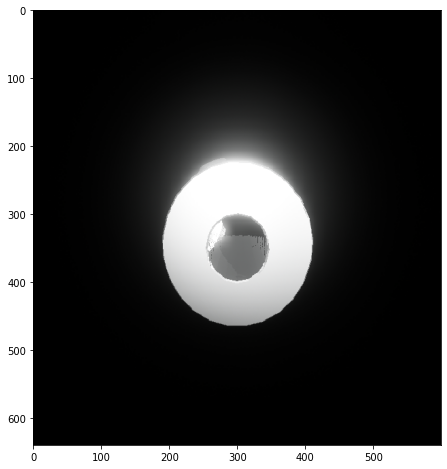

In [ ]:
testset = val_ds.take(1)
print(class_names)

plt.figure(figsize=(8, 8))

#imagetotest = "/content/HighresScreenshot00000.png"

img = tf.keras.utils.load_img(
    imagetotest, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

plt.imshow(img)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


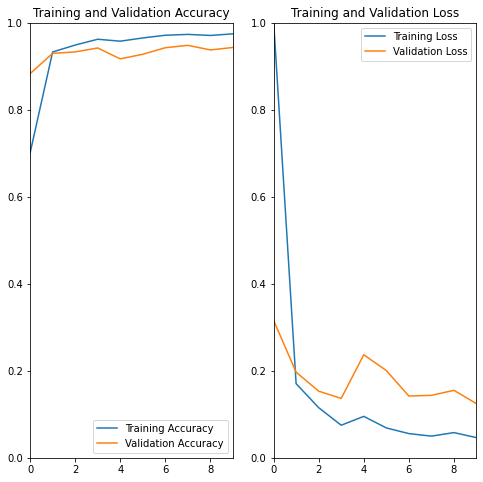

In [ ]:
# PART 2 : Option 1 #  Chart the model just built
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1)
plt.xlim(0,epochs-1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,1)
plt.xlim(0,epochs-1)
#plt.show()

plt.savefig("fullclassrun.png")
#files.download("fullclassrun.png") 

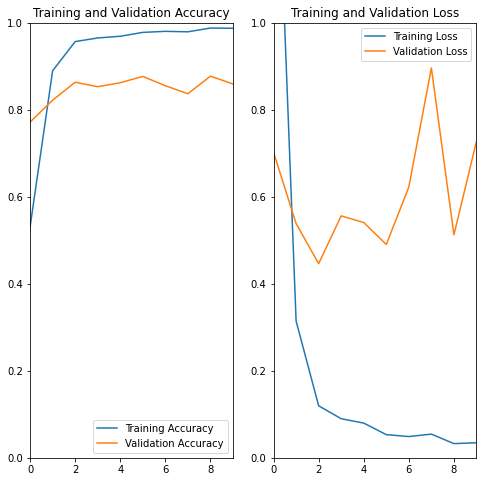

In [ ]:
# PART 2 : Option 2 #  Load previous log and chart

history = '/content/drive/MyDrive/MachineLearningImages/Models/' + todayformatted + "/" + current_class + "/" + 'training.log'

df = pd.read_csv(history, index_col='epoch')

acc = df.loc[:,'accuracy']
val_acc =df.loc[:,'val_accuracy']

loss = df.loc[:,'loss']
val_loss = df.loc[:,'val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1)
plt.xlim(0,epochs-1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,1)
plt.xlim(0,epochs-1)
#plt.show()

plt.savefig("fullclassrun.png")